# Generating a Coloured Italian Map

Author: **J Rogel-Salazar**

We are using Python to create a map of Italy with coloured provinces based on values assigned to each of them.

To reuse this code you need to make sure that you have a shape file for the geographical region you are plotting. 

I am using Python 2 in this example.

You will need some modules from the matplot library and pandas. You will also need to install:
- basemap
- shapely
- descartes

In [5]:
# From matplotlib and pandas
%pylab inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D 
from matplotlib.collections import PatchCollection
import pandas as pd

# Other libraries required:
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
from descartes import PolygonPatch

Populating the interactive namespace from numpy and matplotlib


We are using a CSV file that contains some data for a "total" (think for example population) and a number of "positive" values for each province. 

Let us read the data with pandas and calculate a ratio of "positive" and "total".

In [10]:
df1 = pd.read_csv("../data/ItalianProvincesData.csv",keep_default_na=False,na_values=['_'])

In [11]:
df1.head()

,PROVINCE,ProvinceMap,Positive,Total
0,AG,IT.AG,890,4774
1,AL,IT.AL,1104,10533
2,AN,IT.AN,1203,11158
3,AO,IT.AO,176,1412
4,AP,IT.AP,266,2980


In [12]:
df1['Density']=df1["Positive"]/df1["Total"]

In [13]:
df1.head()

,PROVINCE,ProvinceMap,Positive,Total,Density
0,AG,IT.AG,890,4774,0.186426
1,AL,IT.AL,1104,10533,0.104813
2,AN,IT.AN,1203,11158,0.107815
3,AO,IT.AO,176,1412,0.124646
4,AP,IT.AP,266,2980,0.089262


# Load the Shape File for Italy

You need to provide appropriate latitude and longitude entries for the geographical area you need to plot. 

- llcrnrlon: longitude of lower left hand corner of the desired map domain (degrees).
- llcrnrlat: latitude of lower left hand corner of the desired map domain (degrees).
- urcrnrlon: longitude of upper right hand corner of the desired map domain (degrees).
- urcrnrlat: latitude of upper right hand corner of the desired map domain (degrees).

See the Basemap documentation [here](http://matplotlib.org/basemap/api/basemap_api.html)

(113,
 5,
 [6.630878925323543, 35.492916107177905, 0.0, 0.0],
 [18.520694732666122, 47.09096145629885, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x115f422d0>)

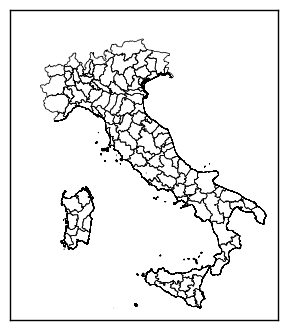

In [16]:
m = Basemap(llcrnrlon=6,llcrnrlat=36,urcrnrlon=20,urcrnrlat=48, 
            resolution='i',projection='tmerc',lon_0=13,lat_0=43)


m.readshapefile("../data/ITA_adm_shp/ITA_adm2", "italy")

Let us create a dictionary of that links the name of the province to the density calculated above:

In [18]:
italian_provinces = pd.Series(df1['Density'].values, index=df1['ProvinceMap']).to_dict()

Let us look at the maximum and minimum values. These are important as we will need them to colour the map with a graded shade.

In [19]:
max_val = np.max(italian_provinces.values())

print(max_val)

min_val = np.min(italian_provinces.values())

print(min_val)

0.258973534769
0.0646542496253


## Colouring map

We need to create patches of colour that correspond to the shape file entries. In this case the names of the provinces are encoded in the "HASC_2" field. 

In [20]:
state_patches = []
for coordinates, state in zip(m.italy, m.italy_info):
    #print state["HASC_2"]
    if state["HASC_2"] in italian_provinces.keys():
        shade = italian_provinces[state["HASC_2"]]/float(max_val)
        state_patches.append(PolygonPatch(Polygon(coordinates), fc="red",
                                         ec='#555555', lw=.2, alpha=shade, zorder=4))
        

Finally we can create our map:

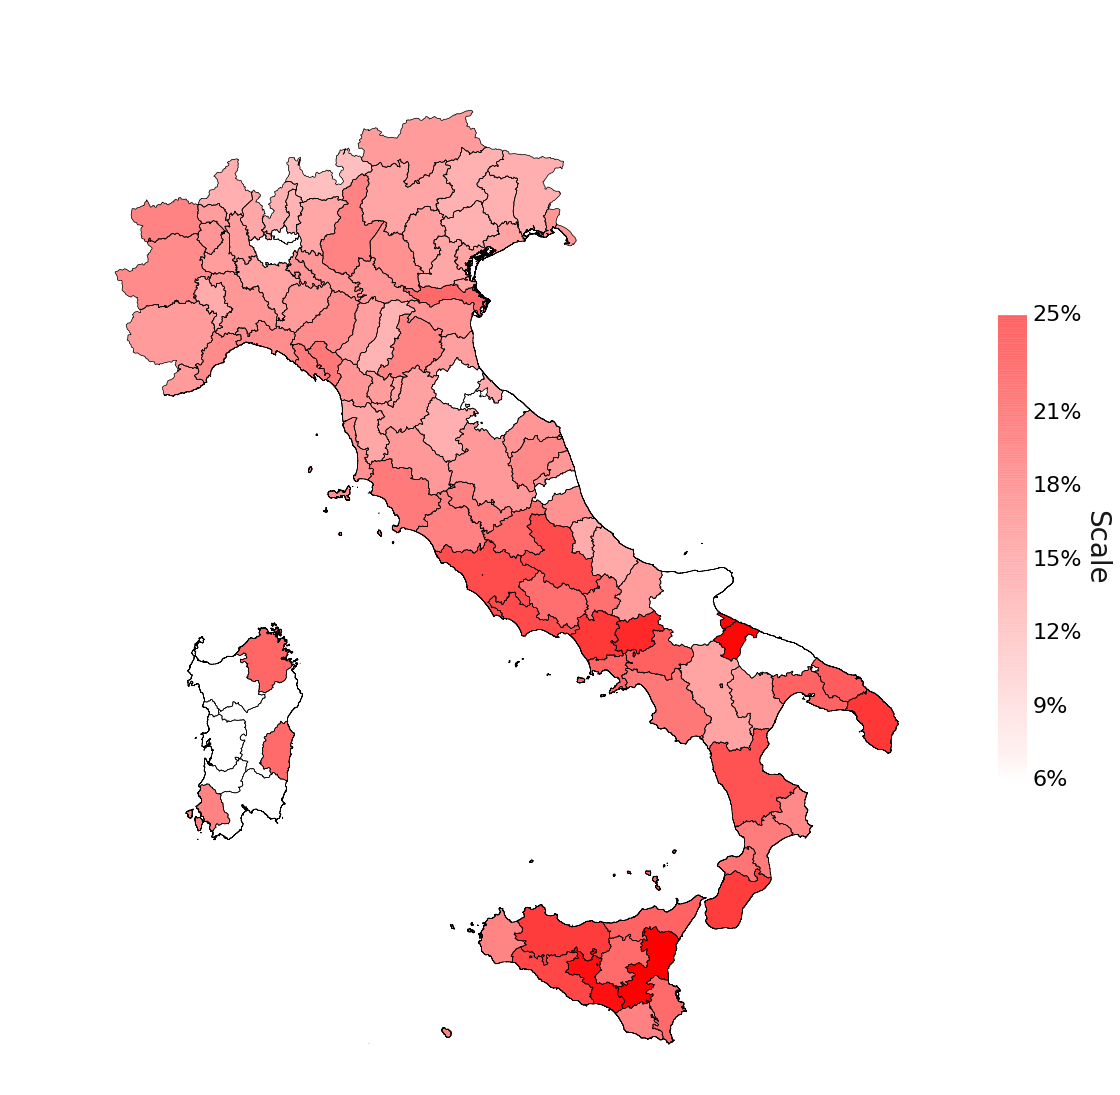

In [25]:
num = float(len(df1))

scale_min = int(min_val*100)
scale_max = int(max_val*100)

customcmap = [(1,  1-(x/num), 1-(x/num)) for x in range(len(df1))]

#fig, ax = plt.subplots(1,1, figsize=(15,15))

fig = plt.figure(figsize=(15,15))
# Add subplot
ax = fig.add_subplot(111)
ttl= 'Churn Rate Map'

ax.set_frame_on(False)

m.readshapefile("../data/ITA_adm_shp/ITA_adm2", "italy")
ax.add_collection(PatchCollection(state_patches, match_original=True))

# Create a fake colorbar
ctb = LinearSegmentedColormap.from_list('custombar', customcmap, N=2048)
# Trick from http://stackoverflow.com/questions/8342549/
# matplotlib-add-colorbar-to-a-sequence-of-line-plots

sm = plt.cm.ScalarMappable(cmap=ctb, norm=matplotlib.colors.Normalize(vmin=scale_min, vmax=scale_max))
#sm = plt.cm.ScalarMappable(cmap=Reds, norm=matplotlib.colors.Normalize(vmin=72, vmax=84))


# Fake up the array of the scalar mappable
sm._A = []
 
# Set colorbar, aspect ratio
cbar = plt.colorbar(sm, alpha=0.05, aspect=16, shrink=0.4)
cbar.solids.set_edgecolor("face")
# Remove colorbar container frame
cbar.outline.set_visible(False)
# Fontsize for colorbar ticklabels
cbar.ax.tick_params(labelsize=16)
# Customize colorbar tick labels

mytks=np.linspace(scale_min, scale_max, 7)
mytks = [int(x) for x in mytks]

cbar.set_ticks(mytks)
cbar.ax.set_yticklabels(["{0:.0f}%".format(a) for a in mytks])#,alpha = a)
 
# Colorbar label, customize fontsize and distance to colorbar
cbar.set_label('Scale', alpha=a, 
               rotation=270, fontsize=20, labelpad=20)
# Remove color bar tick lines, while keeping the tick labels
cbarytks = plt.getp(cbar.ax.axes, 'yticklines')
plt.setp(cbarytks, visible=False)

# You can save the map to a PNG file with the following command
plt.savefig('Density.png', bbox_inches='tight', dpi=300)